In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 전처리 - 정규화 - train set 클러스터링

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
import platform
import matplotlib as mpl
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
#from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DAT 사각김밥_(머신러닝 스터디)/data6.csv', index_col=0)
df = df.loc[:, ~df.columns.isin(['창업이전', '창업이후'])]
df['기업형태'] = np.where(df['기업형태'] == '법인', 1, 0)
df.rename(columns={'기업형태':'법인기업'}, inplace=True)
df['창업자 학력'].value_counts()
df['창업자학력'] = df['창업자 학력'].map({'중졸이하':1, '고졸':2, '전문대졸':3, '대졸':4, '석사':5, '박사':5})

df = df.drop('창업자 학력', axis=1)
df['창업자학력'].value_counts()
df['사업장 입지'].value_counts()
df['상업지역'] = df['사업장 입지'].map({'일반상업':1, '일반주택':0, '기타':0, '산업단지':0, '대학':0})

df = df.drop('사업장 입지', axis=1)
df['상업지역'].value_counts()
df

법인기업  창업횟수  창업인원      매출액      영업이익  금융비용(이자비용)     당기순이익  \
0         1     1     1   265000   15100.0       900.0    4750.0   
2         1     2     2   677000   63045.0     29020.0   46147.0   
3         1     1     1  3936000  264000.0     34300.0  139300.0   
4         1     1     1  5668000  170900.0     18300.0  144850.0   
5         1     1     1    85000    2100.0      1200.0    2050.0   
...     ...   ...   ...      ...       ...         ...       ...   
31974     1     1     3   524000  152900.0         0.0  110300.0   
31975     1     1     1   782300   31200.0         0.0   22500.0   
31976     0     1     1   526000  191900.0         0.0  138500.0   
31977     0     1     1   620000  201500.0       400.0  145400.0   
31978     0     1     6   803300   93600.0         0.0   22500.0   

       B2C 소비자 매출(%)  B2G 정부 매출(%)  연간 자금 사용금액  전체 인력  자산대비 자금사용비율  창업자학력  \
0                100             0    101850.0      1    55.218459      1   
2                100             0    136948.0      4   970.206210      1   
3                  0             0    288880.0     17    32.130989      1   
4                100             0    572130.0     26    15.765648      1   
5                100             0    110900.0      2  1896.979261      1   
...              ...           ...         ...    ...          ...    ...   
31974              0             0    882000.0      6    15.873016      4   
31975              0             0    380000.0      9    23.947368      4   
31976            100             0     16000.0      7   481.250000      4   
31977             70             0   1162800.0     15    12.039904      4   
31978            100             0     80000.0      2   778.750000      2   

       상업지역  
0         0  
2         1  
3         0  
4         0  
5         0  
...     ...  
31974     0  
31975     1  
31976     0  
31977     0  
31978     0  

[22540 rows x 14 columns]

In [4]:
df.columns

Index(['법인기업', '창업횟수', '창업인원', '매출액', '영업이익', '금융비용(이자비용)', '당기순이익',
       'B2C 소비자 매출(%)', 'B2G 정부 매출(%)', '연간 자금 사용금액', '전체 인력', '자산대비 자금사용비율',
       '창업자학력', '상업지역'],
      dtype='object')

In [5]:
def replace_space_with_underscore(df):
    df.columns = df.columns.str.replace(' ', '')
    return df

# 데이터프레임의 열 이름에서 공백을 언더스코어로 대체
df = replace_space_with_underscore(df)
df.rename(columns={'B2G정부매출(%)': 'B2G정부매출'}, inplace=True)
df.rename(columns={'B2C소비자매출(%)': 'B2C소비자매출'}, inplace=True)
df.rename(columns={'금융비용(이자비용)': '금융비용'}, inplace=True)


In [6]:
# 연속형 변수 정규화
scale_col = ['매출액', '영업이익', '금융비용', '연간자금사용금액', '자산대비자금사용비율']
scaler = StandardScaler()
df[scale_col] = scaler.fit_transform(df[scale_col])

In [7]:
# 클러스터링
from sklearn.cluster import AgglomerativeClustering
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df['당기순이익_scale'] = scaler.fit_transform(train_df[['당기순이익']])
agg = AgglomerativeClustering(n_clusters=3)
pre_col=['법인기업', '창업횟수', '창업인원', '매출액', '영업이익', '금융비용', '당기순이익_scale', 'B2C소비자매출',
       'B2G정부매출', '연간자금사용금액', '전체인력', '자산대비자금사용비율', '창업자학력', '상업지역']
train_df['AgglomerativeClustering']=agg.fit_predict(train_df[pre_col])
train_df.drop(axis=1,columns='당기순이익_scale',inplace= True)

In [8]:
train_df.head()

법인기업  창업횟수  창업인원       매출액      영업이익      금융비용    당기순이익  B2C소비자매출  \
25043     1     1     1 -0.305189 -0.063867 -0.090588  19200.0       100   
27250     1     1     2 -0.308345 -0.080236 -0.090282   3500.0         0   
15623     0     2     1 -0.011138 -0.037384 -0.090588  43700.0       100   
26218     1     2     1 -0.280840  0.001507 -0.090588  28100.0         0   
16795     0     1     2 -0.285938 -0.535350  0.034843   2880.0       100   

       B2G정부매출  연간자금사용금액  전체인력  자산대비자금사용비율  창업자학력  상업지역  \
25043        0 -0.131088     0   -0.081663      5     0   
27250        0 -0.213632     0   -0.060056      2     0   
15623        0  0.026446    15   -0.081725      4     1   
26218        0 -0.091882     1   -0.081599      5     0   
16795        0  0.013853     0   -0.070661      4     0   

       AgglomerativeClustering  
25043                        1  
27250                        0  
15623                        1  
26218                        0  
16795                        1

## original df 에 군집column 추가

In [9]:
df_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DAT 사각김밥_(머신러닝 스터디)/data6.csv', index_col=0)
df_original = df_original.loc[:, ~df_original.columns.isin(['창업이전', '창업이후'])]
df_original['기업형태'] = np.where(df_original['기업형태'] == '법인', 1, 0)
df_original.rename(columns={'기업형태':'법인기업'}, inplace=True)
df_original['창업자 학력'].value_counts()
df_original['창업자학력'] = df_original['창업자 학력'].map({'중졸이하':1, '고졸':2, '전문대졸':3, '대졸':4, '석사':5, '박사':5})

df_original = df_original.drop('창업자 학력', axis=1)
df_original['창업자학력'].value_counts()
df_original['사업장 입지'].value_counts()
df_original['상업지역'] = df_original['사업장 입지'].map({'일반상업':1, '일반주택':0, '기타':0, '산업단지':0, '대학':0})

df_original = df_original.drop('사업장 입지', axis=1)
df_original['상업지역'].value_counts()
df_original

법인기업  창업횟수  창업인원      매출액      영업이익  금융비용(이자비용)     당기순이익  \
0         1     1     1   265000   15100.0       900.0    4750.0   
2         1     2     2   677000   63045.0     29020.0   46147.0   
3         1     1     1  3936000  264000.0     34300.0  139300.0   
4         1     1     1  5668000  170900.0     18300.0  144850.0   
5         1     1     1    85000    2100.0      1200.0    2050.0   
...     ...   ...   ...      ...       ...         ...       ...   
31974     1     1     3   524000  152900.0         0.0  110300.0   
31975     1     1     1   782300   31200.0         0.0   22500.0   
31976     0     1     1   526000  191900.0         0.0  138500.0   
31977     0     1     1   620000  201500.0       400.0  145400.0   
31978     0     1     6   803300   93600.0         0.0   22500.0   

       B2C 소비자 매출(%)  B2G 정부 매출(%)  연간 자금 사용금액  전체 인력  자산대비 자금사용비율  창업자학력  \
0                100             0    101850.0      1    55.218459      1   
2                100             0    136948.0      4   970.206210      1   
3                  0             0    288880.0     17    32.130989      1   
4                100             0    572130.0     26    15.765648      1   
5                100             0    110900.0      2  1896.979261      1   
...              ...           ...         ...    ...          ...    ...   
31974              0             0    882000.0      6    15.873016      4   
31975              0             0    380000.0      9    23.947368      4   
31976            100             0     16000.0      7   481.250000      4   
31977             70             0   1162800.0     15    12.039904      4   
31978            100             0     80000.0      2   778.750000      2   

       상업지역  
0         0  
2         1  
3         0  
4         0  
5         0  
...     ...  
31974     0  
31975     1  
31976     0  
31977     0  
31978     0  

[22540 rows x 14 columns]

In [10]:
def replace_space_with_underscore(df):
    df.columns = df.columns.str.replace(' ', '')
    return df

# 데이터프레임의 열 이름에서 공백을 언더스코어로 대체
df_original = replace_space_with_underscore(df_original)
df_original.rename(columns={'B2G정부매출(%)': 'B2G정부매출'}, inplace=True)
df_original.rename(columns={'B2C소비자매출(%)': 'B2C소비자매출'}, inplace=True)
df_original.rename(columns={'금융비용(이자비용)': '금융비용'}, inplace=True)


In [11]:
train_df_original, test_df_original = train_test_split(df_original, test_size=0.2, random_state=42)
train_df_original

법인기업  창업횟수  창업인원      매출액      영업이익     금융비용    당기순이익  B2C소비자매출  \
25043     1     1     1    27700   19200.0      0.0  19200.0       100   
27250     1     1     2    14700    3500.0    100.0   3500.0         0   
15623     0     2     1  1239000   44600.0      0.0  43700.0       100   
26218     1     2     1   128000   81900.0      0.0  28100.0         0   
16795     0     1     2   107000 -433000.0  41000.0   2880.0       100   
...     ...   ...   ...      ...       ...      ...      ...       ...   
16651     1     1     1  1271000   53664.0  14893.0  28867.0       100   
30653     1     1     1    10000       0.0      0.0      0.0       100   
7272      0     1     1   155000    2600.0   1600.0   1250.0       100   
1154      1     2     1  2089000   74600.0   8500.0  22750.0        50   
22261     0     2     2    61300   11034.0      0.0   5402.0       100   

       B2G정부매출   연간자금사용금액  전체인력   자산대비자금사용비율  창업자학력  상업지역  
25043        0   360000.0     0    15.555556      5     0  
27250        0    12600.0     0  1944.444444      2     0  
15623        0  1023000.0    15    10.068426      4     1  
26218        0   525000.0     1    21.333333      5     0  
16795        0   970000.0     0   997.731959      4     0  
...        ...        ...   ...          ...    ...   ...  
16651        0   369300.0     4   127.461413      2     1  
30653        0    45000.0     0   155.555556      5     1  
7272         0   192220.0     5     9.260223      2     1  
1154         0   225990.0     8   188.086199      2     1  
22261        0   248000.0     0    85.161290      2     0  

[18032 rows x 14 columns]

In [12]:
train_df_original = pd.concat([train_df_original, train_df['AgglomerativeClustering']], axis=1)
train_df_original

법인기업  창업횟수  창업인원      매출액      영업이익     금융비용    당기순이익  B2C소비자매출  \
25043     1     1     1    27700   19200.0      0.0  19200.0       100   
27250     1     1     2    14700    3500.0    100.0   3500.0         0   
15623     0     2     1  1239000   44600.0      0.0  43700.0       100   
26218     1     2     1   128000   81900.0      0.0  28100.0         0   
16795     0     1     2   107000 -433000.0  41000.0   2880.0       100   
...     ...   ...   ...      ...       ...      ...      ...       ...   
16651     1     1     1  1271000   53664.0  14893.0  28867.0       100   
30653     1     1     1    10000       0.0      0.0      0.0       100   
7272      0     1     1   155000    2600.0   1600.0   1250.0       100   
1154      1     2     1  2089000   74600.0   8500.0  22750.0        50   
22261     0     2     2    61300   11034.0      0.0   5402.0       100   

       B2G정부매출   연간자금사용금액  전체인력   자산대비자금사용비율  창업자학력  상업지역  \
25043        0   360000.0     0    15.555556      5     0   
27250        0    12600.0     0  1944.444444      2     0   
15623        0  1023000.0    15    10.068426      4     1   
26218        0   525000.0     1    21.333333      5     0   
16795        0   970000.0     0   997.731959      4     0   
...        ...        ...   ...          ...    ...   ...   
16651        0   369300.0     4   127.461413      2     1   
30653        0    45000.0     0   155.555556      5     1   
7272         0   192220.0     5     9.260223      2     1   
1154         0   225990.0     8   188.086199      2     1   
22261        0   248000.0     0    85.161290      2     0   

       AgglomerativeClustering  
25043                        1  
27250                        0  
15623                        1  
26218                        0  
16795                        1  
...                        ...  
16651                        1  
30653                        1  
7272                         1  
1154                         0  
22261                        1  

[18032 rows x 15 columns]

In [23]:
train_df_original.columns = ['법인기업', '창업횟수', '창업인원', '매출액', '영업이익', '금융비용', '당기순이익', 'B2C소비자매출비중(%)',
       'B2G정부매출비중(%)', '연간자금사용금액', '전체인력', '자산대비자금사용비율(%)', '창업자학력', '상업지역',
       'AgglomerativeClustering']

In [24]:
# 군집별 데이터 프레임 분할
df_군집0=train_df_original[train_df_original['AgglomerativeClustering']==0]
df_군집1=train_df_original[train_df_original['AgglomerativeClustering']==1]
df_군집2=train_df_original[train_df_original['AgglomerativeClustering']==2]

In [25]:
df_군집0

법인기업  창업횟수  창업인원      매출액       영업이익     금융비용     당기순이익  B2C소비자매출비중(%)  \
27250     1     1     2    14700    3500.00   100.00   3500.00              0   
26218     1     2     1   128000   81900.00     0.00  28100.00              0   
11502     0     1     2   467000    4500.00   100.00   4300.00              0   
6977      0     1     1  4974000 -101475.00     0.00 -86794.00              0   
18697     0     1     1    98000    4900.00     0.00   1960.00              0   
...     ...   ...   ...      ...        ...      ...       ...            ...   
7157      0     1     1    33000  -57296.00 17832.00 -66931.00             50   
1034      1     1     1   367000   13700.00  1900.00   5050.00              0   
22595     0     1     1   240000    7236.00     0.00  10506.00              0   
23789     1     1     1   200300    4500.00     0.00   2448.00             30   
1154      1     2     1  2089000   74600.00  8500.00  22750.00             50   

       B2G정부매출비중(%)  연간자금사용금액  전체인력  자산대비자금사용비율(%)  창업자학력  상업지역  \
27250             0  12600.00     0        1944.44      2     0   
26218             0 525000.00     1          21.33      5     0   
11502             0 693000.00     2          23.81      2     0   
6977              0 583170.00   137         132.74      5     1   
18697             0 240000.00     0           3.33      4     0   
...             ...       ...   ...            ...    ...   ...   
7157              0  85023.00     6         503.80      5     1   
1034              0  17740.00     2          25.25      2     1   
22595             0  45000.00     2         279.44      2     0   
23789             0  17430.00     1          19.51      4     1   
1154              0 225990.00     8         188.09      2     1   

       AgglomerativeClustering  
27250                        0  
26218                        0  
11502                        0  
6977                         0  
18697                        0  
...                        ...  
7157                         0  
1034                         0  
22595                        0  
23789                        0  
1154                         0  

[6874 rows x 15 columns]

In [26]:
numerical_cols =['매출액', '영업이익', '금융비용', '당기순이익', 'B2C소비자매출비중(%)',
       'B2G정부매출비중(%)', '연간자금사용금액', '전체인력', '자산대비자금사용비율(%)']
numerical_cols

['매출액',
 '영업이익',
 '금융비용',
 '당기순이익',
 'B2C소비자매출비중(%)',
 'B2G정부매출비중(%)',
 '연간자금사용금액',
 '전체인력',
 '자산대비자금사용비율(%)']

In [27]:
categorial_cols = ['법인기업', '창업횟수', '창업인원', '창업자학력', '상업지역']
categorial_cols

['법인기업', '창업횟수', '창업인원', '창업자학력', '상업지역']

In [28]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [29]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

## 연속형 변수

In [30]:
# 군집별 당기순이익 비교

desc_군집0 = df_군집0['당기순이익'].describe()
desc_군집1 = df_군집1['당기순이익'].describe()
desc_군집2 = df_군집2['당기순이익'].describe()

summary_df = pd.concat([desc_군집0, desc_군집1, desc_군집2], axis=1)
summary_df.columns = ['군집 0', '군집 1', '군집 2']

pd.set_option('display.float_format', '{:.2f}'.format)
summary_df

군집 0         군집 1        군집 2
count      6874.00     10247.00      911.00
mean      43900.47     38457.28    50376.43
std     1275469.39    498085.63   272852.08
min   -87243682.00 -18786426.00 -1623017.00
25%        2212.50       650.00     1000.00
50%       18744.00      6000.00    10900.00
75%       71698.00     30000.00    50985.00
max    18285300.00  17978968.00  4170558.00

In [31]:
from matplotlib.ticker import ScalarFormatter

### 히트맵

[Text(0.5, 1.0, 'Heatmap of numerical features')]

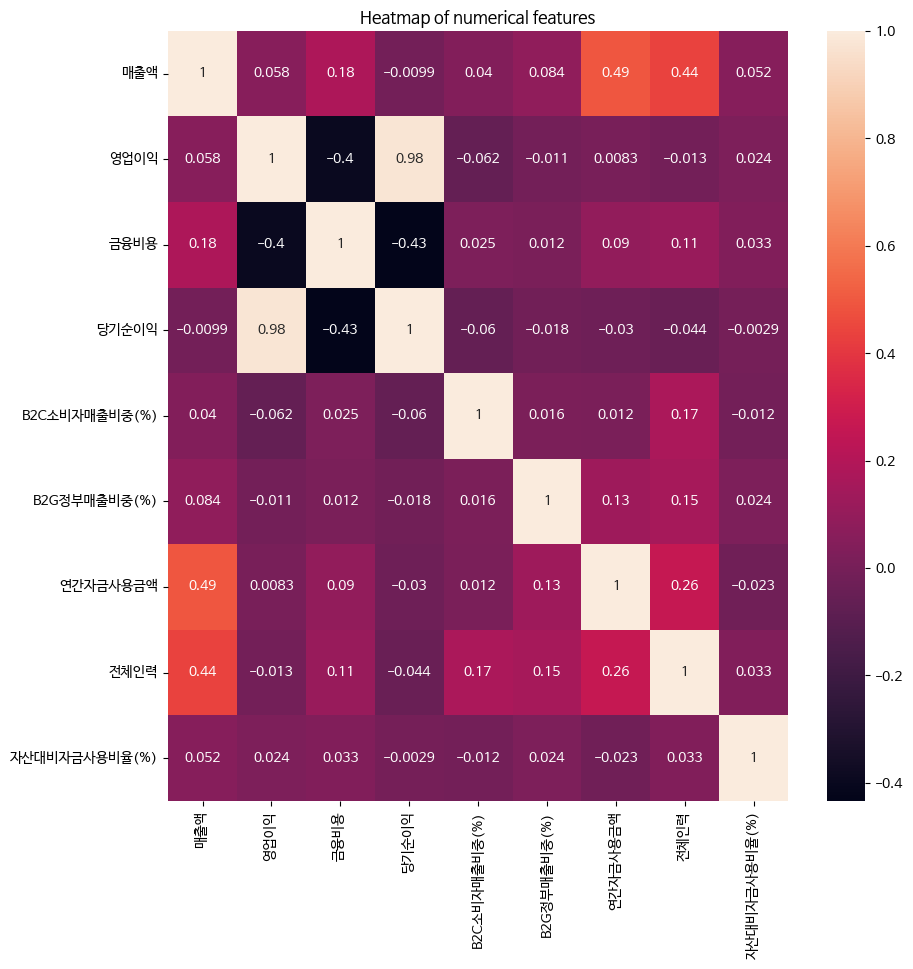

In [32]:
# 히트맵
corrMat = df_군집0[numerical_cols].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True)
ax.set(title='Heatmap of numerical features')

[Text(0.5, 1.0, 'Heatmap of numerical features')]

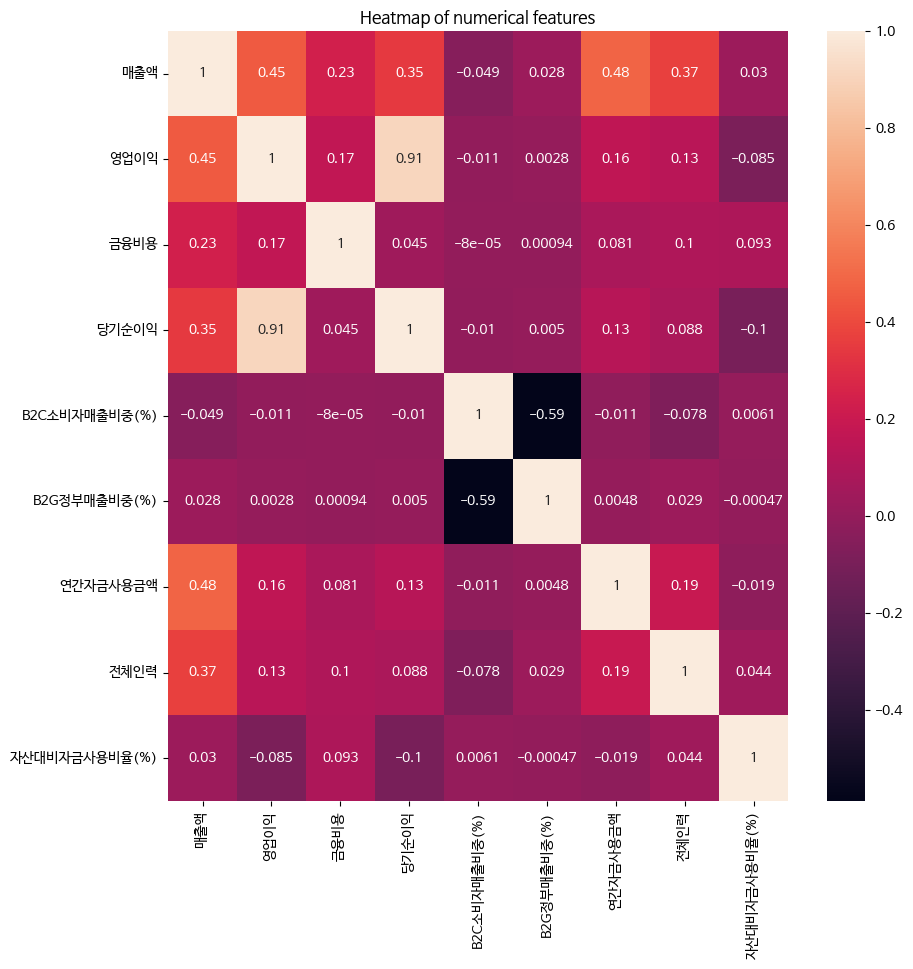

In [33]:
# 히트맵
corrMat = df_군집1[numerical_cols].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True)
ax.set(title='Heatmap of numerical features')

[Text(0.5, 1.0, 'Heatmap of numerical features')]

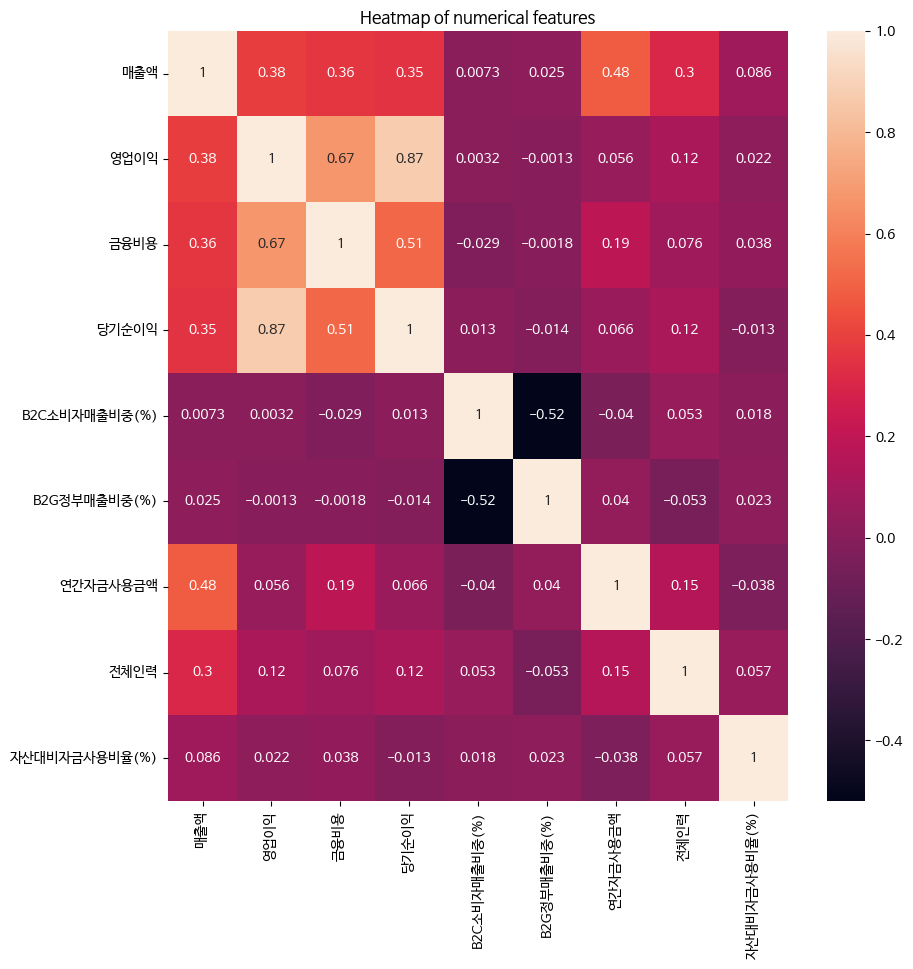

In [34]:
# 히트맵
corrMat = df_군집2[numerical_cols].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True)
ax.set(title='Heatmap of numerical features')

### 당기순이익 평균

AgglomerativeClustering
0   43900.47
1   38457.28
2   50376.43
Name: 당기순이익, dtype: float64


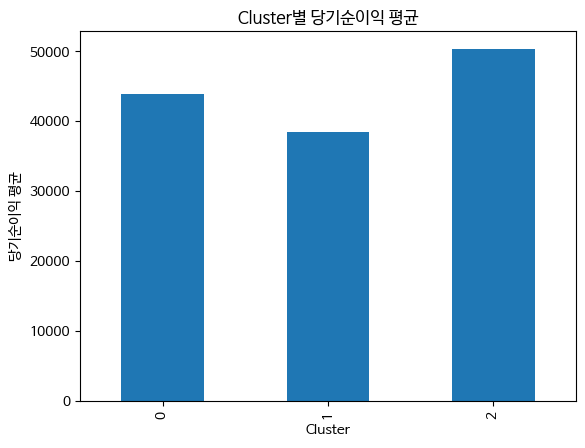

In [35]:
# 군집별 당기순이익 평균 비교

import pandas as pd
import matplotlib.pyplot as plt


# 각 클러스터의 '당기순이익' 평균 계산
cluster_means = train_df_original.groupby('AgglomerativeClustering')['당기순이익'].mean()
print(cluster_means)

# 바 그래프 그리기
cluster_means.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('당기순이익 평균')
plt.title('Cluster별 당기순이익 평균')
plt.show()


### 연속형 변수별 평균치 비교

In [36]:
numerical_cols =['매출액', '영업이익', '금융비용', 'B2C소비자매출비중(%)',
       'B2G정부매출비중(%)', '연간자금사용금액', '전체인력', '자산대비자금사용비율(%)']
numerical_cols

['매출액',
 '영업이익',
 '금융비용',
 'B2C소비자매출비중(%)',
 'B2G정부매출비중(%)',
 '연간자금사용금액',
 '전체인력',
 '자산대비자금사용비율(%)']

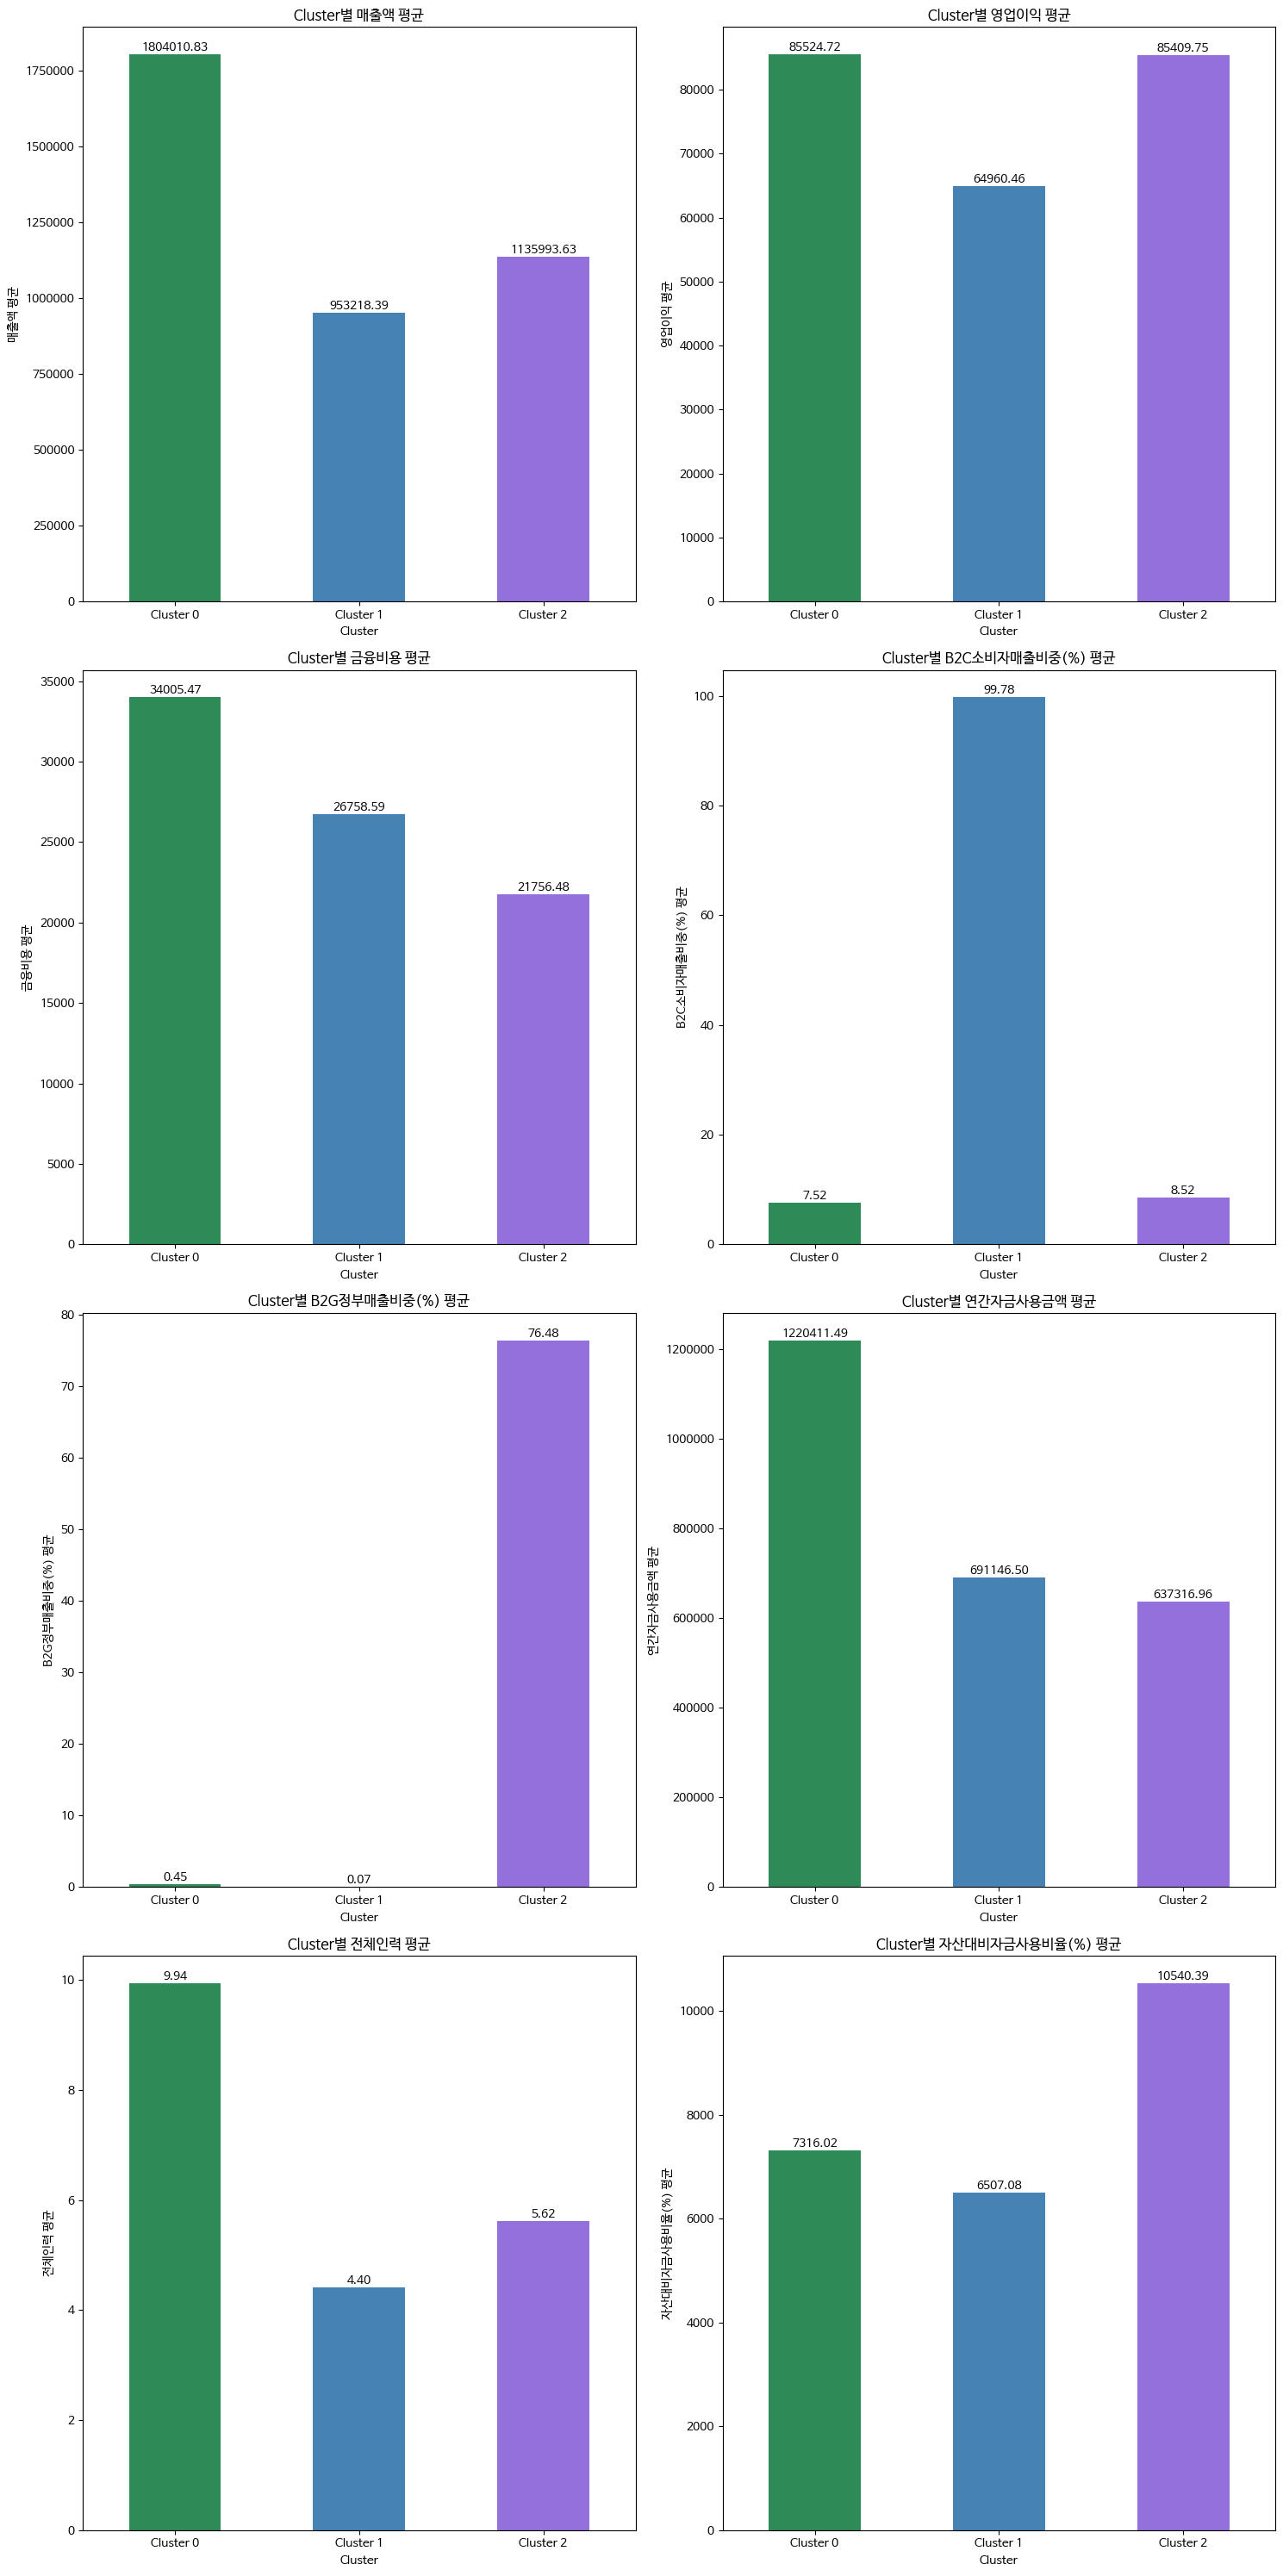

In [37]:

# 군집별 연속형 변수 평균치 비교
fig, axes = plt.subplots(4, 2, figsize=(15, 30))
axes = axes.flatten()  # 2D 배열을 1D 배열로 변환
colors = ['seagreen', 'steelblue', 'mediumpurple']

for idx, col in enumerate(numerical_cols):
    cluster_means = train_df_original.groupby('AgglomerativeClustering')[col].mean()
    bars = cluster_means.plot(kind='bar', rot=0, ax=axes[idx], color=colors)
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(f'{col} 평균')
    axes[idx].set_title(f'Cluster별 {col} 평균')
    axes[idx].set_xticklabels([f'Cluster {i}' for i in range(len(cluster_means))])

    # 지수 표기법 해제
    formatter = ScalarFormatter(useOffset=False)
    formatter.set_scientific(False)
    axes[idx].yaxis.set_major_formatter(formatter)

    # 각 막대에 텍스트 표시 (100 이하인 경우)
    for bar in bars.containers[0]:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])  # 남는 서브플롯 삭제

plt.tight_layout()
plt.show()


## 범주형 변수

In [38]:
print(categorial_cols)

['법인기업', '창업횟수', '창업인원', '창업자학력', '상업지역']


In [39]:
'''
import numpy as np

fig, axes = plt.subplots(3, 2, figsize=(15, 20))

for idx, col in enumerate(categorial_cols):
    row = idx // 2
    col_pos = idx % 2

    cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', col]).size().unstack(fill_value=0)
    cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0)

    width = 0.2  # 막대의 너비
    x = np.arange(len(cluster_corp_freq_ratio))  # x 값 범위 설정

    for i, corp in enumerate(cluster_corp_freq_ratio.columns):
        # 각 고윳값에 대한 막대 그래프를 서로 다른 위치에 그림
        bars = axes[row, col_pos].bar(x + width * i, cluster_corp_freq_ratio[corp], width=width, label=f'{corp}')

    # X 축 설정
    axes[row, col_pos].set_xlabel('Cluster')
    axes[row, col_pos].set_ylabel('비율')
    axes[row, col_pos].set_title(f'클러스터별 {col} 비율')
    axes[row, col_pos].set_xticks(x + width * (len(cluster_corp_freq_ratio.columns) - 1) / 2)  # 막대 중앙에 X 축 레이블 설정
    axes[row, col_pos].set_xticklabels(cluster_corp_freq_ratio.index)  # X 축 레이블 설정


    # 범례 설정
    axes[row, col_pos].legend(title=col)

plt.show()
'''

"\nimport numpy as np\n\nfig, axes = plt.subplots(3, 2, figsize=(15, 20))\n\nfor idx, col in enumerate(categorial_cols):\n    row = idx // 2\n    col_pos = idx % 2\n\n    cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', col]).size().unstack(fill_value=0)\n    cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0)\n\n    width = 0.2  # 막대의 너비\n    x = np.arange(len(cluster_corp_freq_ratio))  # x 값 범위 설정\n\n    for i, corp in enumerate(cluster_corp_freq_ratio.columns):\n        # 각 고윳값에 대한 막대 그래프를 서로 다른 위치에 그림\n        bars = axes[row, col_pos].bar(x + width * i, cluster_corp_freq_ratio[corp], width=width, label=f'{corp}')\n\n    # X 축 설정\n    axes[row, col_pos].set_xlabel('Cluster')\n    axes[row, col_pos].set_ylabel('비율')\n    axes[row, col_pos].set_title(f'클러스터별 {col} 비율')\n    axes[row, col_pos].set_xticks(x + width * (len(cluster_corp_freq_ratio.columns) - 1) / 2)  # 막대 중앙에 X 축 레이블 설정\n    axes[row, col_pos].set_xticklabels(cl

In [40]:
'''
fig, axes = plt.subplots(3, 2, figsize=(15, 20))

for idx, col in enumerate(categorial_cols):
    row = idx // 2
    col_pos = idx % 2
    cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', col]).size().unstack(fill_value=0)
    cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0)

    cluster_corp_freq_ratio.plot(kind='bar',  stacked=True, ax=axes[row, col_pos])
    axes[row, col_pos].set_xlabel('Cluster')
    axes[row, col_pos].set_ylabel('비율')
    axes[row, col_pos].set_title(f'클러스터별 {col} 비율')
    axes[row, col_pos].legend(title=col)
    axes[row, col_pos].set_xticklabels([f'Cluster {i}' for i in range(len(cluster_corp_freq_ratio))])

for i in range(len(numerical_cols), 5):
    fig.delaxes(axes[i])  # 남는 서브플롯 삭제

plt.show()
'''

"\nfig, axes = plt.subplots(3, 2, figsize=(15, 20))\n\nfor idx, col in enumerate(categorial_cols):\n    row = idx // 2\n    col_pos = idx % 2\n    cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', col]).size().unstack(fill_value=0)\n    cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0)\n\n    cluster_corp_freq_ratio.plot(kind='bar',  stacked=True, ax=axes[row, col_pos])\n    axes[row, col_pos].set_xlabel('Cluster')\n    axes[row, col_pos].set_ylabel('비율')\n    axes[row, col_pos].set_title(f'클러스터별 {col} 비율')\n    axes[row, col_pos].legend(title=col)\n    axes[row, col_pos].set_xticklabels([f'Cluster {i}' for i in range(len(cluster_corp_freq_ratio))])\n\nfor i in range(len(numerical_cols), 5):\n    fig.delaxes(axes[i])  # 남는 서브플롯 삭제\n\nplt.show()\n"

### 법인기업

In [41]:
# 클러스터별 법인기업 비율

cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '법인기업']).size().unstack(fill_value=0)
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100  # 비율에 100을 곱하여 퍼센트로 변환

width = 0.2  # 막대의 너비
x = np.arange(len(cluster_corp_freq_ratio))  # x 값 범위 설정
fig, ax = plt.subplots(figsize=(10, 8))

for i, corp in enumerate(cluster_corp_freq_ratio.columns):
    # 각 고윳값에 대한 막대 그래프를 서로 다른 위치에 그림
    bars = ax.bar(x + width * i, cluster_corp_freq_ratio[corp], width=width, label=f'{corp}')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom')  # 비율에 100을 곱해 %로 표시

# X 축 설정
ax.set_xlabel('Cluster')
ax.set_ylabel('비율 (%)')
ax.set_title('클러스터별 법인기업 비율')
ax.set_xticks(x + width * (len(cluster_corp_freq_ratio.columns) - 1) / 2)  # 막대 중앙에 X 축 레이블 설정
ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_corp_freq_ratio))])  # X 축 레이블 설정

# 범례 설정
ax.legend(title='법인기업')

plt.show()

In [42]:
# 각 클러스터별 법인기업 비율

cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '법인기업']).size().unstack(fill_value=0)
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100
cluster_corp_freq_ratio = cluster_corp_freq_ratio.applymap(lambda x: f'{x:.2f}%')

print("클러스터별 법인기업 비율(%):")
cluster_corp_freq_ratio

클러스터별 법인기업 비율(%):


법인기업                          0       1
AgglomerativeClustering                
0                        53.23%  46.77%
1                        46.35%  53.65%
2                        55.21%  44.79%

### 창업횟수

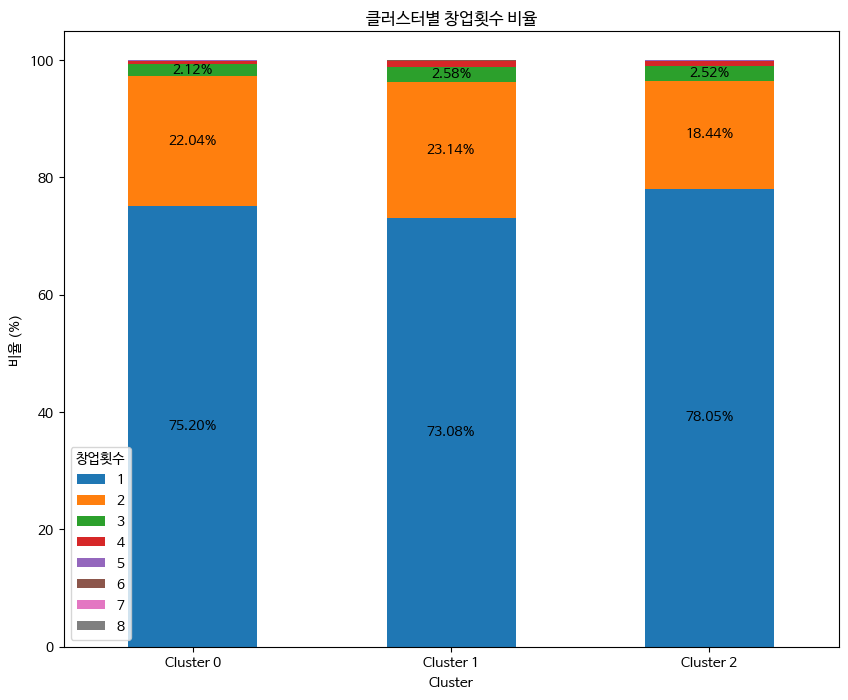

In [43]:
# 클러스터별 창업횟수 비율

# 클러스터별 고윳값의 빈도
cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '창업횟수']).size().unstack(fill_value=0)
# 빈도를 퍼센트로 변환
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
bar_plot = cluster_corp_freq_ratio.plot(kind='bar', stacked=True, ax=ax, rot=0)

ax.set_xlabel('Cluster')
ax.set_ylabel('비율 (%)')
ax.set_title('클러스터별 창업횟수 비율')
ax.legend(title='창업횟수')

ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_corp_freq_ratio))])

# 비율 텍스트 추가
for p in bar_plot.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height >= 2:  # 비율이 2% 이상인 경우에만
        ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()

In [44]:
# 클러스터별 창업횟수 비율

cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '창업횟수']).size().unstack(fill_value=0)
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100
cluster_corp_freq_ratio = cluster_corp_freq_ratio.applymap(lambda x: f'{x:.2f}%')

print("클러스터별 창업횟수 비율:")
cluster_corp_freq_ratio

클러스터별 창업횟수 비율:


창업횟수                          1       2      3      4      5      6      7  \
AgglomerativeClustering                                                      
0                        75.20%  22.04%  2.12%  0.52%  0.09%  0.00%  0.01%   
1                        73.08%  23.14%  2.58%  0.98%  0.14%  0.10%  0.00%   
2                        78.05%  18.44%  2.52%  0.88%  0.11%  0.00%  0.00%   

창업횟수                         8  
AgglomerativeClustering         
0                        0.01%  
1                        0.00%  
2                        0.00%

In [45]:
# 클러스터별 창업횟수 빈도
print("클러스터별 창업횟수 빈도:")
cluster_corp_freq

클러스터별 창업횟수 빈도:


창업횟수                        1     2    3    4   5   6  7  8
AgglomerativeClustering                                    
0                        5169  1515  146   36   6   0  1  1
1                        7488  2371  264  100  14  10  0  0
2                         711   168   23    8   1   0  0  0

### 창업인원

In [46]:
# 클러스터별 창업인원 비율

# 클러스터별 고윳값의 빈도
cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '창업인원']).size().unstack(fill_value=0)
# 빈도를 퍼센트로 변환
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
bar_plot = cluster_corp_freq_ratio.plot(kind='bar', stacked=True, ax=ax, rot=0)

ax.set_xlabel('Cluster')
ax.set_ylabel('비율 (%)')
ax.set_title('클러스터별 창업인원 비율')
ax.legend(title='창업인원')

ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_corp_freq_ratio))])

# 비율 텍스트 추가
for p in bar_plot.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height >= 2:  # 비율이 2% 이상인 경우에만
        ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()

In [47]:
# 클러스터별 창업인원 비율

cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '창업인원']).size().unstack(fill_value=0)
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100
cluster_corp_freq_ratio = cluster_corp_freq_ratio.applymap(lambda x: f'{x:.2f}%')

print("클러스터별 창업인원 비율:")
cluster_corp_freq_ratio

클러스터별 창업인원 비율:


창업인원                         1      2      3      4      5      6      7   \
AgglomerativeClustering                                                     
0                        84.83%  9.53%  3.59%  0.51%  0.55%  0.33%  0.45%   
1                        85.35%  8.44%  4.09%  0.52%  0.94%  0.25%  0.31%   
2                        87.82%  8.23%  2.31%  0.22%  1.10%  0.33%  0.00%   

창업인원                        8      10     11     12     14     15     22  
AgglomerativeClustering                                                   
0                        0.04%  0.04%  0.04%  0.00%  0.01%  0.04%  0.01%  
1                        0.05%  0.03%  0.01%  0.01%  0.00%  0.00%  0.00%  
2                        0.00%  0.00%  0.00%  0.00%  0.00%  0.00%  0.00%

In [48]:
# 클러스터별 창업인원 빈도
print("클러스터별 창업인원 빈도:")
cluster_corp_freq

클러스터별 창업인원 빈도:


창업인원                       1    2    3   4   5   6   7   8   10  11  12  14  \
AgglomerativeClustering                                                       
0                        5831  655  247  35  38  23  31   3   3   3   0   1   
1                        8746  865  419  53  96  26  32   5   3   1   1   0   
2                         800   75   21   2  10   3   0   0   0   0   0   0   

창업인원                     15  22  
AgglomerativeClustering          
0                         3   1  
1                         0   0  
2                         0   0

### 창업자 학력

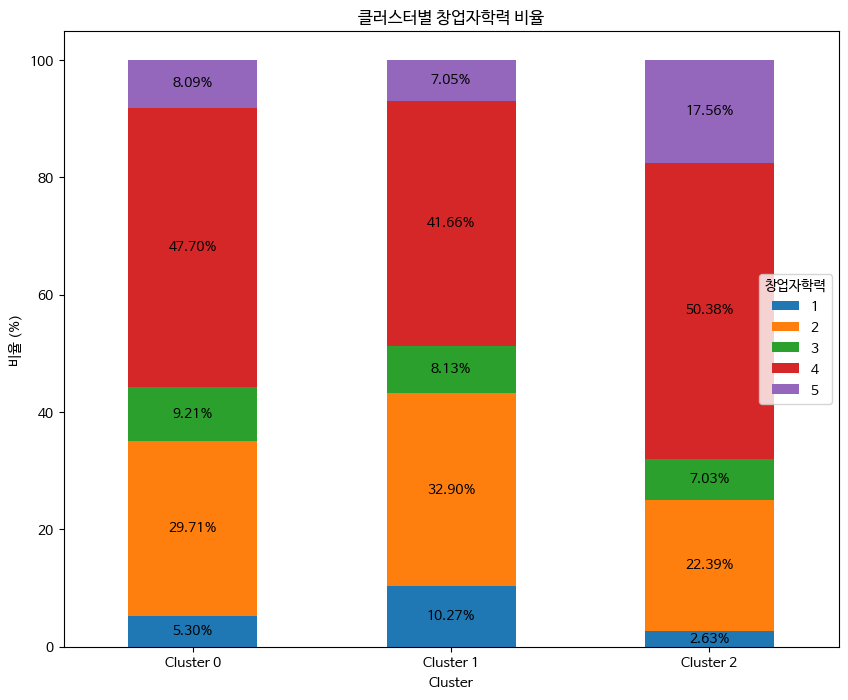

In [49]:
# 클러스터별 창업자학력 비율

# 클러스터별 고윳값의 빈도
cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '창업자학력']).size().unstack(fill_value=0)
# 빈도를 퍼센트로 변환
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
bar_plot = cluster_corp_freq_ratio.plot(kind='bar', stacked=True, ax=ax, rot=0)

ax.set_xlabel('Cluster')
ax.set_ylabel('비율 (%)')
ax.set_title('클러스터별 창업자학력 비율')
ax.legend(title='창업자학력')

ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_corp_freq_ratio))])

# 비율 텍스트 추가
for p in bar_plot.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height >= 2:  # 비율이 2% 이상인 경우에만
        ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()

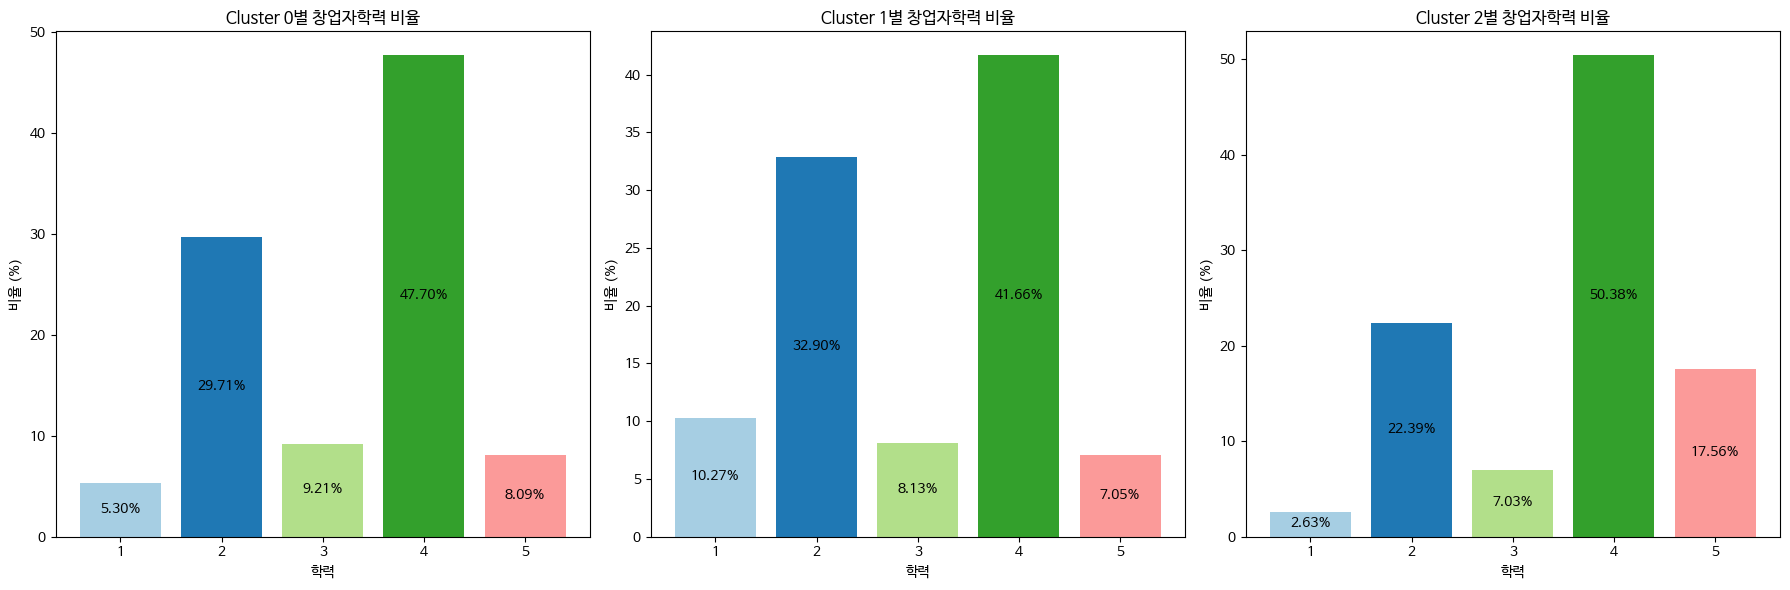

In [50]:

# 각 클러스터별 창업자학력 고윳값의 빈도 계산
cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '창업자학력']).size().unstack(fill_value=0)
# 클러스터별 고윳값의 빈도를 비율로 변환
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1행 3열의 subplot을 생성합니다.

# 각 클러스터에 대해 별도의 subplot에 막대 그래프를 그립니다.
for i, cluster in enumerate(cluster_corp_freq_ratio.index):
    ax = axes[i]
    cluster_data = cluster_corp_freq_ratio.loc[cluster]
    bars = ax.bar(cluster_data.index, cluster_data.values, color=plt.cm.Paired.colors[:len(cluster_data)])

    ax.set_xlabel('학력')
    ax.set_ylabel('비율 (%)')
    ax.set_title(f'Cluster {cluster}별 창업자학력 비율')

    # 비율 텍스트 추가
    for bar in bars:
        height = bar.get_height()
        if height >= 2:  # 비율이 2% 이상인 경우에만
            ax.annotate(f'{height:.2f}%', (bar.get_x() + bar.get_width() / 2, height / 2), ha='center', va='center')

plt.tight_layout()
plt.show()


In [51]:
# 클러스터별 창업자학력 비율

cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '창업자학력']).size().unstack(fill_value=0)
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100
cluster_corp_freq_ratio = cluster_corp_freq_ratio.applymap(lambda x: f'{x:.2f}%')

print("클러스터별 창업자학력 비율:")
cluster_corp_freq_ratio

클러스터별 창업자학력 비율:


창업자학력                         1       2      3       4       5
AgglomerativeClustering                                       
0                         5.30%  29.71%  9.21%  47.70%   8.09%
1                        10.27%  32.90%  8.13%  41.66%   7.05%
2                         2.63%  22.39%  7.03%  50.38%  17.56%

### 상업지역

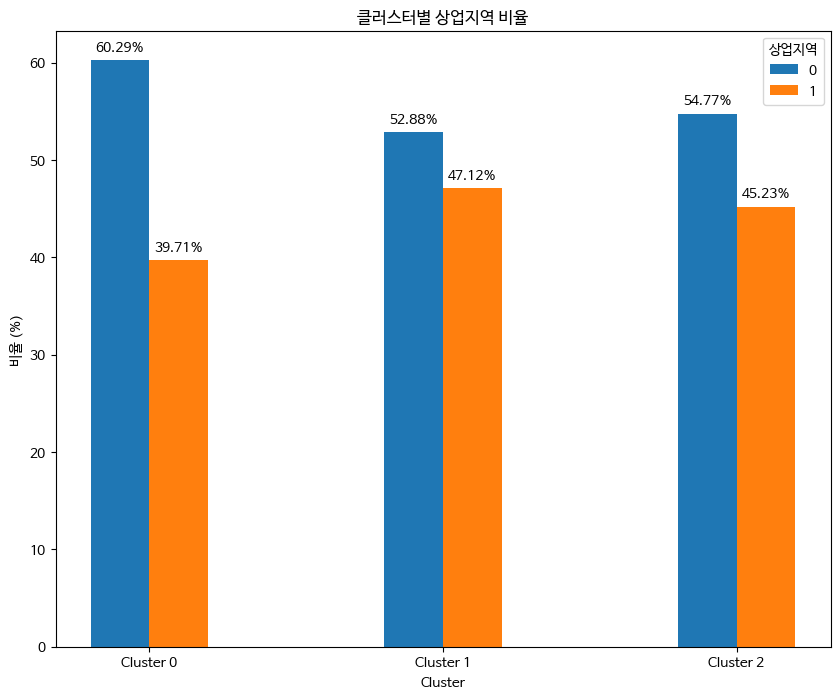

In [52]:
# 클러스터별 상업지역 비율

cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '상업지역']).size().unstack(fill_value=0)
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100  # 비율에 100을 곱하여 퍼센트로 변환

width = 0.2  # 막대의 너비
x = np.arange(len(cluster_corp_freq_ratio))  # x 값 범위 설정
fig, ax = plt.subplots(figsize=(10, 8))

for i, corp in enumerate(cluster_corp_freq_ratio.columns):
    # 각 고윳값에 대한 막대 그래프를 서로 다른 위치에 그림
    bars = ax.bar(x + width * i, cluster_corp_freq_ratio[corp], width=width, label=f'{corp}')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom')  # 비율에 100을 곱해 %로 표시

# X 축 설정
ax.set_xlabel('Cluster')
ax.set_ylabel('비율 (%)')
ax.set_title('클러스터별 상업지역 비율')
ax.set_xticks(x + width * (len(cluster_corp_freq_ratio.columns) - 1) / 2)  # 막대 중앙에 X 축 레이블 설정
ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_corp_freq_ratio))])  # X 축 레이블 설정

# 범례 설정
ax.legend(title='상업지역')

plt.show()

In [54]:
# 클러스터별 상업지역 비율

cluster_corp_freq = train_df_original.groupby(['AgglomerativeClustering', '상업지역']).size().unstack(fill_value=0)
cluster_corp_freq_ratio = cluster_corp_freq.div(cluster_corp_freq.sum(axis=1), axis=0) * 100
cluster_corp_freq_ratio = cluster_corp_freq_ratio.applymap(lambda x: f'{x:.2f}%')

print("클러스터별 상업지역 비율:")
cluster_corp_freq_ratio

클러스터별 상업지역 비율:


상업지역                          0       1
AgglomerativeClustering                
0                        60.29%  39.71%
1                        52.88%  47.12%
2                        54.77%  45.23%